In [114]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
import optuna
import seaborn as sns

In [115]:
# load in 2022 mlb season data

df = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022_processed.csv")

# load in 2023 mlb season data

df_2023 = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2023_processed.csv")

In [116]:
# load in linear weights for events

linear_weights = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\linear_weights.csv")

In [117]:
# load in calculated expected metrics

xpfx_x = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\pfx_2022&3_xpfx.csv")
xpfx_z = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\IVB_2022&3_xpfz.csv")
xspin_axis = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\axis_2022&3_xaxis.csv")

xswing = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\swing_2022&3_xswing.csv")
xwhiff = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\whiff_2022&3_xwhiff.csv")
xfb = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\fb_2022&3_xfb.csv")
xgrb = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\gb_2022&3_xgb.csv")
xld = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\ld_2022&3_xld.csv")
xfoul = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\foul_2022&3_xfoul.csv")
xcs = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\cs_2022&3_xcalledstrike.csv")
diff2022 = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\2022_diffs.csv")
diff2023 = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\2023_diffs.csv")

In [118]:
# rename and drop columns from expected dfs

xpfx_x = xpfx_x[['pitch_id_raw', 'xpfx_x']]
xpfx_z = xpfx_z[['pitch_id_raw', 'xpfx_z']]
xspin_axis = xspin_axis[['pitch_id_raw', 'diff']]
xswing = xswing[['pitch_id_raw', 'xswing']]
xwhiff = xwhiff[['pitch_id_raw', 'xwhiff']]
xfb = xfb[['pitch_id_raw', 'xfb']]
xgrb = xgrb[['pitch_id_raw', 'xgb']]
xld = xld[['pitch_id_raw', 'xld']]
xfoul = xfoul[['pitch_id_raw', 'xfoul']]
xcs = xcs[['pitch_id_raw', 'xcs']]
diffs = pd.concat([diff2022, diff2023], axis=0)
diffs = diffs[['pitch_id_raw', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed']]

In [119]:
# ensure df is sequential

df.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

stand_encoder = LabelEncoder()
all_stand = pd.concat([df['stand'], df_2023['stand']]).unique()
stand_encoder.fit(all_stand)

df['stand'] = stand_encoder.transform(df['stand'])

# generate unique id column

df['pitch_id_raw'] = df['game_pk'].astype(str) + "_" + \
                            df['batter'].astype(str) + "_" + \
                            df['pitcher'].astype(str) + "_" + \
                            df['pitch_number'].astype(str) + "_" + \
                            df['at_bat_number'].astype(str) + "_" + \
                            df['inning'].astype(str)

# select only offspeed

df = df[df['pitch_type'].isin(['CH', 'FS'])]

# normalize LHP values to RHP standards

df.loc[df['p_throws'] == 'L', 'pfx_x'] = df['pfx_x'] * -1
df.loc[df['p_throws'] == 'L', 'release_pos_x'] = df['release_pos_x'] * -1
df.loc[df['p_throws'] == 'L', 'spin_axis'] = 360 - df['spin_axis']

# total movement column

df['pfx_total'] = abs(df['pfx_x']) + abs(df['pfx_z'])

# movement ratio column

df['pfx_x_ratio'] = abs(df['pfx_x']) / df['pfx_total']
df['pfx_z_ratio'] = abs(df['pfx_z']) / df['pfx_total']

In [120]:
# ensure df is sequential

df_2023.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

df_2023['stand'] = stand_encoder.transform(df_2023['stand'])

# generate unique id column

df_2023['pitch_id_raw'] = df_2023['game_pk'].astype(str) + "_" + \
                            df_2023['batter'].astype(str) + "_" + \
                            df_2023['pitcher'].astype(str) + "_" + \
                            df_2023['pitch_number'].astype(str) + "_" + \
                            df_2023['at_bat_number'].astype(str) + "_" + \
                            df_2023['inning'].astype(str)

# select only offspeed

df_2023 = df_2023[df_2023['pitch_type'].isin(['CH', 'FS'])]

# normalize LHP values to RHP standards

df_2023.loc[df_2023['p_throws'] == 'L', 'pfx_x'] = df_2023['pfx_x'] * -1
df_2023.loc[df_2023['p_throws'] == 'L', 'release_pos_x'] = df_2023['release_pos_x'] * -1
df.loc[df['p_throws'] == 'L', 'spin_axis'] = 360 - df['spin_axis']

# total movement column
df_2023['pfx_total'] = abs(df_2023['pfx_x']) + abs(df_2023['pfx_z'])

# movement ratio column
df_2023['pfx_x_ratio'] = abs(df_2023['pfx_x']) / df_2023['pfx_total']
df_2023['pfx_z_ratio'] = abs(df_2023['pfx_z']) / df_2023['pfx_total']

In [121]:
pitch_type_map = {
        "FF": "FF", "FT": "SI", "FC": "CT",
        "SL": "SL", "ST": "SL", "SV": "SL",
        "CH": "CH", "FS": "SP",
        "CU": "CB", "KC": "CB", "CS": "CB", "CB": "CB",
        "SI": "SI", "KN": "KN", "FA": "FF", "FT": "SI"
    }

df_2023['pitch_type'] = df_2023['pitch_type'].map(pitch_type_map)
df['pitch_type'] = df['pitch_type'].map(pitch_type_map)

In [122]:
# create outcome column using events and description columns

events_mapping = {
    'field_out': 'field_out',
    'force_out': 'field_out',
    'fields_choice_out': 'field_out',
    'fielders_choice': 'field_out',
    'other_out': 'field_out',
    'sac_fly': 'field_out',
    'sac_bunt': 'field_out',
    'walk': 'walk',
    'hit_by_pitch': 'walk',
    'strikeout': 'strikeout',
    'grounded_into_double_play': 'double_play',
    'double_play': 'double_play',
    'strikeout_double_play': 'double_play',
    'sac_fly_double_play': 'double_play',
    'single': 'single',
    'double': 'double',
    'triple': 'triple',
    'home_run': 'home_run'    
}


description_mapping = {
    'ball': 'ball',
    'called_strike': 'strike',
    'foul': 'foul',
    'swinging_strike': 'strike',
    'foul_tip': 'foul',
    'hit_by_pitch': 'walk',
    'blocked_ball': 'ball' ,
    'missed_bunt': 'strike',
    'foul_bunt': 'foul',
    'swinging_strike_blocked': 'strike',
    'bunt_foul_tip': 'foul'
}

In [123]:
# function for using mappings to determine outcome

def determine_outcome(row):
    
    event = row['events']
    description = row['description']
    
    if event in events_mapping:
        return events_mapping[event]

    elif description in description_mapping:
        return description_mapping[description]

    else:
        return np.nan

# apply function to each row

df['outcome'] = df.apply(determine_outcome, axis=1)
df_2023['outcome'] = df_2023.apply(determine_outcome, axis=1)

In [124]:
# drop na outcome rows

df.dropna(subset=['outcome'], inplace=True)
df_2023.dropna(subset=['outcome'], inplace=True)

In [125]:
# create outcome label encoder

outcome_encoder = LabelEncoder()

# get all possible outcome values

all_outcome = pd.concat([df['outcome'], df_2023['outcome']]).unique()
outcome_encoder.fit(all_outcome)

# label encode the outcome column

df['outcome'] = outcome_encoder.transform(df['outcome'])
df_2023['outcome'] = outcome_encoder.transform(df_2023['outcome'])

In [126]:
# perform left joins

df = pd.merge(df, xpfx_x, on='pitch_id_raw', how='left')
df = pd.merge(df, xpfx_z, on='pitch_id_raw', how='left')
df = pd.merge(df, xspin_axis, on='pitch_id_raw', how='left')
df = pd.merge(df, xswing, on='pitch_id_raw', how='left')
df = pd.merge(df, xwhiff, on='pitch_id_raw', how='left')
df = pd.merge(df, xfb, on='pitch_id_raw', how='left')
df = pd.merge(df, xgrb, on='pitch_id_raw', how='left')
df = pd.merge(df, xld, on='pitch_id_raw', how='left')
df = pd.merge(df, xfoul, on='pitch_id_raw', how='left')
df = pd.merge(df, xcs, on='pitch_id_raw', how='left')
df = pd.merge(df, diffs, on='pitch_id_raw', how='left')

In [127]:
# perform left joins

df_2023 = pd.merge(df_2023, xpfx_x, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xpfx_z, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xspin_axis, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xswing, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xwhiff, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xfb, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xgrb, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xld, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xfoul, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xcs, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, diffs, on='pitch_id_raw', how='left')

In [128]:
# convert all negative swing probabilities to zero (bug)

df.loc[df['xswing'] < 0, 'xswing'] = 0
df_2023.loc[df_2023['xswing'] < 0, 'xswing'] = 0

In [129]:
# create combination term of swing and whiff probabilities

df['swing_whiff'] = df['xswing'] * df['xwhiff']
df_2023['swing_whiff'] = df_2023['xswing'] * df_2023['xwhiff']

In [130]:
# feature selection and data splitting

columns = ['outcome', 'player_name', 'pitch_type', 'spin_axis', 'ax', 'vz0', 'az', 'vx0', 'ay', 'vy0', 'release_speed', 'release_pos_x', 'release_pos_y', \
           'release_pos_z', 'release_extension', 'release_spin_rate', 'pfx_z', 'pfx_x', 'pfx_total', 'pfx_x_ratio', 'pfx_z_ratio',\
           'xpfx_x', 'xpfx_z', 'diff', 'xwhiff', 'xswing', 'swing_whiff', 'xfb', 'xgb', 'xld', 'xfoul', 'xcs', 'delta_run_exp', 'rolling_avg_velo', 'diff_spin_axis',\
           'diff_pfx_x', 'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed']

features = ['spin_axis', 'ax', 'vz0', 'az', 'vx0', 'ay', 'vy0', 'release_speed', 'release_pos_x', 'release_pos_y', \
           'release_pos_z', 'release_extension', 'release_spin_rate', 'pfx_z', 'pfx_x', 'pfx_total', 'pfx_x_ratio', 'pfx_z_ratio',\
           'xpfx_x', 'xpfx_z', 'diff', 'xwhiff', 'xswing', 'swing_whiff', 'xfb', 'xgb', 'xld', 'xfoul', 'xcs', 'rolling_avg_velo', 'diff_spin_axis',\
            'diff_pfx_x', 'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed']

# drop any rows with nan values

df = df[columns]
df = df.dropna()

# create features and targets

X = df[features]
y = df['outcome']

In [131]:
# train valid test split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [132]:
# optuna tuning block

#def objective(trial):
    
    # define hyperparameters
    
    #params = {
        #'max_depth': trial.suggest_int('max_depth', 3, 9),
        #'learning_rate': trial.suggest_float('eta', 0.01, 0.3),
        #'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        #'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        #'objective': 'multi:softmax',
        #'num_class': len(np.unique(y_train)),
        #'eval_metric': 'mlogloss',
        #'use_label_encoder': False
    #}

    # initialize model
    
    #model = xgb.XGBClassifier(**params, n_estimators=100)

    # train the model
    
    #model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=50, verbose=False)

    # predict on validation set
    
    #y_valid_pred = model.predict_proba(X_valid)

    # calculate log loss on the validation set
    
    #loss = log_loss(y_valid, y_valid_pred)

    #return loss

#create an optuna study and specifcy the the direction of the optimization

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=100)

# print best parameters

#print(study.best_params)

In [133]:
# set up model

params = {
        'max_depth': 6,
        'eta': 0.1044289896836109,
        'subsample': 0.8838491939084707,
        'colsample_bytree': 0.9518679684601651,
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y_train)),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

# initialize model
    
model = xgb.XGBClassifier(**params, n_estimators=100)

# train model

model.fit(X_train, y_train)

c:\Users\adam.bloebaum\AppData\Local\miniconda3\envs\driveline\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9518679684601651, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1044289896836109,
              eval_metric='mlogloss', feature_types=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=11,
              num_parallel_tree=None, ...)

In [134]:
# make predictions

y_pred = model.predict(X_valid)

# evaluate the model

accuracy = accuracy_score(y_valid, y_pred)
conf_matrix = confusion_matrix(y_valid, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.49075964031555136
Confusion Matrix:
[[6074    0    0   66  276    0    3  419   17    0    0]
 [  28    9    0   68   47    0   53   44    1    0    0]
 [  28    0    0    4   35    0    4   44    1    0    0]
 [ 489   11    0  210  795    0   85  729    2    0    0]
 [ 756    1    0  141 1028    0   14 1025   20    0    0]
 [  11    0    0    4   41    0    5   58    0    0    0]
 [ 177    8    0  131  154    0  129  140    1    0    0]
 [ 869    1    0  147  811    0   14 1432   11    0    0]
 [ 610    0    0   39  219    0    2  260   14    0    0]
 [   0    0    0    8    2    0    2    2    0    0    0]
 [ 274    0    0    2    8    0    0   14    0    0    0]]


<Figure size 1000x5000 with 0 Axes>

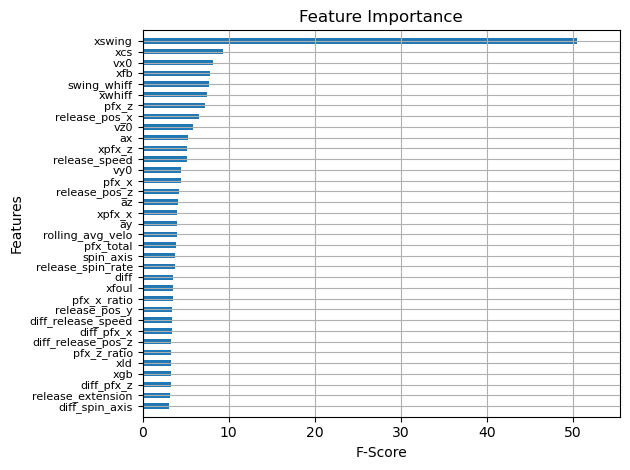

In [135]:
# plot feature importance

plt.figure(figsize=(10, 50))
xgb.plot_importance(model, importance_type='gain', show_values=False, height=0.5)
plt.title('Feature Importance')
plt.xlabel('F-Score')
plt.ylabel('Features')
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig('os_feature_importance.png', dpi=300)
plt.show()

In [136]:
# get feature importance dictionary

importance = model.get_booster().get_score(importance_type='gain')

# sort features by importance

sorted_importance = sorted(importance.items(), key=lambda item: item[1], reverse=True)

# loop to print

for feature, score in sorted_importance:
    print(f'{feature}: {score}')

xswing: 50.430850982666016
xcs: 9.3474702835083
vx0: 8.134027481079102
xfb: 7.803205490112305
swing_whiff: 7.745561599731445
xwhiff: 7.44735050201416
pfx_z: 7.302682876586914
release_pos_x: 6.562476634979248
vz0: 5.810797691345215
ax: 5.253246784210205
xpfx_z: 5.203327655792236
release_speed: 5.160626411437988
vy0: 4.473997116088867
pfx_x: 4.4275007247924805
release_pos_z: 4.279905796051025
az: 4.07773494720459
xpfx_x: 4.0565409660339355
ay: 4.027278900146484
rolling_avg_velo: 4.007843971252441
pfx_total: 3.934231996536255
spin_axis: 3.7520599365234375
release_spin_rate: 3.7228362560272217
diff: 3.5289881229400635
xfoul: 3.5247628688812256
pfx_x_ratio: 3.5133676528930664
release_pos_y: 3.4788966178894043
diff_release_speed: 3.4510257244110107
diff_pfx_x: 3.367048501968384
diff_release_pos_z: 3.3270485401153564
pfx_z_ratio: 3.3189849853515625
xld: 3.3024864196777344
xgb: 3.295790433883667
diff_pfx_z: 3.2817132472991943
release_extension: 3.1604137420654297
diff_spin_axis: 3.059633016586

In [137]:
# copy and keep only features

df_2023_features = df_2023[features]

# generate outcome probabilities on 2023 mlb season data

outcome_probabilities = model.predict_proba(df_2023_features)

# apply outcome probabilities back onto full df

for i, class_label in enumerate(model.classes_):
    df_2023[f'prob_{class_label}'] = outcome_probabilities[:, i]

In [138]:
# label encode linear weights to match outcome

linear_weights = linear_weights[linear_weights['description'] != 'caught_stealing_2b']
linear_weights['outcome'] = outcome_encoder.transform(linear_weights['description'])

In [139]:
linear_weight_values = linear_weights.set_index('outcome')['linear_weight']

# weighted sum of each outcome's probability * each outcome's linear weight run value

df_2023['pitch_quality'] = sum(
    df_2023[f'prob_{i}'] * linear_weight_values[i] for i in range(11)
)

In [140]:
def reformat_name(name):
    parts = name.split(', ')
    if len(parts) == 2:
        return parts[1] + ' ' + parts[0]
    else:
        return name

df['player_name'] = df['player_name'].apply(reformat_name)
df_2023['player_name'] = df_2023['player_name'].apply(reformat_name)

In [141]:
# group by player name and pitch type for pitches a player threw more than 100 times

grouped_data = df_2023.groupby(['player_name', 'pitch_type']).filter(lambda x: len(x) > 100)

# group by player name and pitch type and get the mean pitch quality

pitch_quality_sum = grouped_data.groupby(['player_name', 'pitch_type'])['pitch_quality'].mean().reset_index()

# sort the results by pitch quality in descending order and take the top 10

bottom_10 = pitch_quality_sum.sort_values(by='pitch_quality', ascending=False).head(10)

# sort the results by pitch quality in ascending order and take the bottom 10

top_10 = pitch_quality_sum.sort_values(by='pitch_quality', ascending=True).head(10)

# print results

print("Top 10:")
print(top_10)
print("\nBottom 10:")
print(bottom_10)

Top 10:
           player_name pitch_type  pitch_quality
89      Félix Bautista         SP      -0.039783
123        Jhoan Duran         SP      -0.035964
167      Kyle Finnegan         SP      -0.034577
240  Shintaro Fujinami         SP      -0.033311
87      Framber Valdez         CH      -0.024564
271     Yonny Chirinos         SP      -0.023000
233    Sandy Alcantara         CH      -0.022075
270       Yennier Cano         CH      -0.021949
278       Zack Littell         SP      -0.021657
198      Michael Wacha         CH      -0.021559

Bottom 10:
        player_name pitch_type  pitch_quality
171     Kyle Muller         CH       0.018968
85       Eury Pérez         CH       0.018761
196  Michael Kopech         CH       0.014168
51    Chris Bassitt         SP       0.013180
132    Johan Oviedo         CH       0.011877
75       Drew Smith         CH       0.011457
27     Brady Singer         CH       0.011021
61   Connor Seabold         CH       0.010371
104   Hunter Greene        

In [142]:
# determine max and min avg pitch quality values

max_val = pitch_quality_sum['pitch_quality'].max()
min_val = pitch_quality_sum['pitch_quality'].min()

# create normalized stuff+ metric centered around 100

pitch_quality_sum['stuff_plus'] = max_val - pitch_quality_sum['pitch_quality']
mean_stuff = pitch_quality_sum['stuff_plus'].mean()
scaling_factor = 100 / mean_stuff
pitch_quality_sum['stuff_plus'] = pitch_quality_sum['stuff_plus'] * scaling_factor
pitch_quality_sum['stuff_plus'] += 100 - pitch_quality_sum['stuff_plus'].mean()

# sort by stuff plus in ascending order

sorted_pitch_quality_sum = pitch_quality_sum.sort_values(by='stuff_plus', ascending=False)

# reset index and +1 to get rank column

sorted_pitch_quality_sum = sorted_pitch_quality_sum.reset_index()
sorted_pitch_quality_sum.index = sorted_pitch_quality_sum.index + 1

# convert to int for rounding

sorted_pitch_quality_sum['stuff_plus'] = sorted_pitch_quality_sum['stuff_plus'].astype(int)

# print name, pitch type, and stuff plus top 50

sorted_pitch_quality_sum[['player_name', 'pitch_type', 'stuff_plus']].head(50)

,player_name,pitch_type,stuff_plus
1,Félix Bautista,SP,230
2,Jhoan Duran,SP,215
3,Kyle Finnegan,SP,210
4,Shintaro Fujinami,SP,205
5,Framber Valdez,CH,170
6,Yonny Chirinos,SP,164
7,Sandy Alcantara,CH,161
8,Yennier Cano,CH,160
9,Zack Littell,SP,159
10,Michael Wacha,CH,158


In [143]:
# select top 25 rows

top_25_rows = sorted_pitch_quality_sum[['player_name', 'pitch_type', 'stuff_plus']].head(25)

# plotting rankings as a table

fig, ax = plt.subplots(figsize=(5, 6))
ax.axis('tight')
ax.axis('off')
ax.set_title('Top 25 Offspeed Stuff+')
table = ax.table(cellText=top_25_rows.values,
                 colLabels=top_25_rows.columns,
                 loc='center',
                 cellLoc='center',
                 colLoc='center',
                 colWidths=[0.4, 0.2, 0.2])
plt.tight_layout()

# save fig and close

plt.savefig('os_stuff_plus_rankings.png', dpi=300)
plt.close()

In [144]:
# group by pitcher and pitch type

pp = df_2023.groupby(['player_name', 'pitch_type'])

# calculate sum of delta run expectancy and count of pitches for each pitcher's pitch

rv = pp.agg(total_delta_run_exp=('delta_run_exp', 'sum'),
                      total_pitches=('delta_run_exp', 'count'))

# calculate run value per 100 pitches

rv['run_value_per_100_pitches'] = (rv['total_delta_run_exp'] / rv['total_pitches']) * 100

# filter for pitches thrown at least 100 times and sort

rv = rv[rv['total_pitches'] > 100]
rv = rv.sort_values(by='run_value_per_100_pitches')

# merge with sorted pitch quality sum on player name and pitch type

model_validation_df = pd.merge(sorted_pitch_quality_sum, rv, on=['player_name', 'pitch_type'], how='left')

c:\Users\adam.bloebaum\AppData\Local\miniconda3\envs\driveline\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


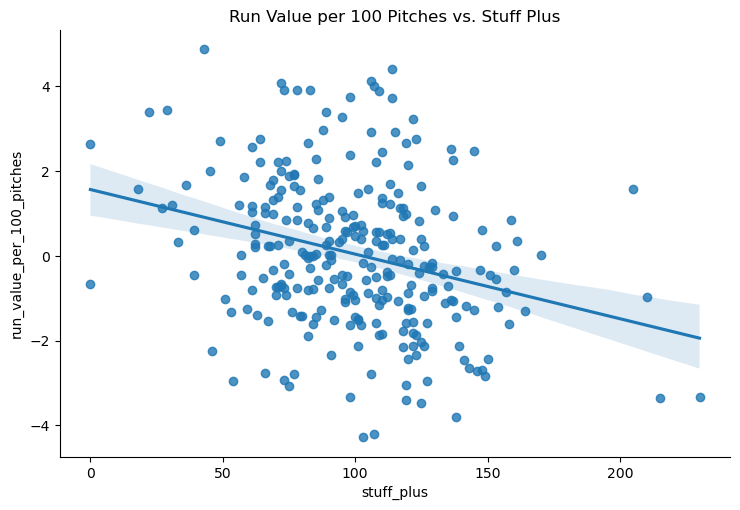

In [145]:
# scatter plot with a regression line

sns.lmplot(x='stuff_plus', y='run_value_per_100_pitches', data=model_validation_df, aspect=1.5)
plt.title('Run Value per 100 Pitches vs. Stuff Plus')
plt.savefig('os_validation_plot_os.png', dpi=300)
plt.show()

In [146]:
# correlation coefficient

correlation = model_validation_df['stuff_plus'].corr(model_validation_df['run_value_per_100_pitches'])
print(f"Correlation Coefficient: {correlation}")


from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score

slope, intercept, r_value, p_value, std_err = stats.linregress(model_validation_df['stuff_plus'], model_validation_df['run_value_per_100_pitches'])
predicted_values = slope * model_validation_df['stuff_plus'] + intercept

# mse and rmse

mse = mean_squared_error(model_validation_df['run_value_per_100_pitches'], predicted_values)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# rsquared

r_squared = r2_score(model_validation_df['run_value_per_100_pitches'], predicted_values)
print(f"R-squared: {r_squared}")

Correlation Coefficient: -0.2890389610995464
Mean Squared Error: 2.8292686678858225
Root Mean Squared Error: 1.6820430041725516
R-squared: 0.08354352103350515


In [147]:
# get pitch count for each pitcher's pitches

pitch_counts = df_2023.groupby(['player_name', 'pitch_type']).size()
count_df = pitch_counts.reset_index(name='count')

# merge pitch counts on pitch quality sum to get stuff plus and pitch count on the same df

os_clean = pd.merge(pitch_quality_sum, count_df, on=['player_name', 'pitch_type'], how='left')
os_clean['stuff_plus'] = os_clean['stuff_plus'].astype(int)
os_clean = os_clean[['player_name', 'pitch_type', 'stuff_plus', 'count']]
offspeed_ready = os_clean.sort_values(by='stuff_plus', ascending=False)
offspeed_ready = offspeed_ready.reset_index(drop=True)
offspeed_ready.index = offspeed_ready.index + 1

In [148]:
# save to y drive

offspeed_ready.to_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\polished_dfs\offspeed_ready.csv")